# 🔹 Paso 1: Iniciar sesión de Spark
En este paso instalamos e inicializamos **PySpark** en Google Colab.  
- Se crea un objeto `SparkSession`, que es la puerta de entrada para trabajar con Spark.  
- Configuramos parámetros como `master("local[*]")` y `shuffle.partitions` para optimizar el trabajo en datasets pequeños.

In [ ]:
# ✅ Paso 1: Instalar e iniciar PySpark en Google Colab
!pip install -q pyspark

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
        .appName("ProyectoMetroSantiago-Regression")
        .master("local[*]")
        .config("spark.sql.session.timeZone", "America/Santiago")
        .getOrCreate()
)

print("🔹 Spark version:", spark.version)
print("🔹 App name:", spark.sparkContext.appName)

🔹 Spark version: 3.5.1
🔹 App name: ProyectoMetroSantiago-Regression


# 🔹 Paso 2: Cargar el dataset
Aquí leemos el archivo `metro_santiago_200.csv` usando `spark.read.csv`.  
- `header=True` indica que la primera fila tiene los nombres de las columnas.  
- `inferSchema=True` permite que Spark detecte automáticamente el tipo de datos.  
- Revisamos el esquema con `printSchema()` y mostramos las primeras filas con `show()`.

In [ ]:
# ✅ Paso 2: Cargar el dataset CSV en un DataFrame de Spark

# Cambia la ruta si lo subiste con otro nombre o ubicación
data_path = "metro_santiago_200.csv"

df = (
    spark.read.option("header", True)     # Usa la primera fila como encabezado
              .option("inferSchema", True) # Infiera tipos de datos automáticamente
              .csv(data_path)
)

# Revisar esquema detectado
df.printSchema()

# Mostrar primeras 10 filas
df.show(10, truncate=False)

root
 |-- id_evento: integer (nullable = true)
 |-- linea: string (nullable = true)
 |-- estacion: string (nullable = true)
 |-- tipo_incidente: string (nullable = true)
 |-- duracion_minutos: integer (nullable = true)
 |-- hora: timestamp (nullable = true)

+---------+-----+--------------+------------------------+----------------+-------------------+
|id_evento|linea|estacion      |tipo_incidente          |duracion_minutos|hora               |
+---------+-----+--------------+------------------------+----------------+-------------------+
|1        |L1   |Baquedano     |Falla eléctrica         |20              |2025-08-29 07:30:00|
|2        |L2   |Cal y Canto   |Mantenimiento           |15              |2025-08-29 22:15:00|
|3        |L3   |Plaza de Armas|Evacuación              |10              |2025-08-29 14:45:00|
|4        |L4   |Las Torres    |Interrupción de servicio|25              |2025-08-29 09:15:00|
|5        |L5   |Santa Ana     |Falla eléctrica         |30              |20

# 🔹 Paso 3: Análisis exploratorio de los datos
Antes de entrenar un modelo, es importante conocer el dataset:  
- Contamos filas y columnas.  
- Revisamos tipos de datos y valores nulos.  
- Creamos nuevas variables como `hora_num` (hora en formato 0–23).  
- Opcionalmente agrupamos por `tipo_incidente` o `linea` para ver duraciones promedio.  
Esto nos ayuda a entender mejor los patrones en los datos.

In [ ]:
from pyspark.sql import functions as F

# Filas y columnas
print("Filas:", df.count(), "| Columnas:", len(df.columns))
df.printSchema()

# Conteo de nulos por columna
nulls = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
nulls.show()

Filas: 200 | Columnas: 6
root
 |-- id_evento: integer (nullable = true)
 |-- linea: string (nullable = true)
 |-- estacion: string (nullable = true)
 |-- tipo_incidente: string (nullable = true)
 |-- duracion_minutos: integer (nullable = true)
 |-- hora: timestamp (nullable = true)

+---------+-----+--------+--------------+----------------+----+
|id_evento|linea|estacion|tipo_incidente|duracion_minutos|hora|
+---------+-----+--------+--------------+----------------+----+
|        0|    0|       0|             0|               0|   0|
+---------+-----+--------+--------------+----------------+----+



In [ ]:
# Tipos de incidente más comunes
df.groupBy("tipo_incidente").count().orderBy(F.desc("count")).show(truncate=False)

# Incidentes por línea
df.groupBy("linea").count().orderBy("linea").show()

# Top estaciones con más incidentes
df.groupBy("estacion").count().orderBy(F.desc("count")).show(10, truncate=False)

+------------------------+-----+
|tipo_incidente          |count|
+------------------------+-----+
|Falla eléctrica         |50   |
|Mantenimiento           |50   |
|Evacuación              |49   |
|Interrupción de servicio|26   |
|Retraso                 |25   |
+------------------------+-----+

+-----+-----+
|linea|count|
+-----+-----+
|   L1|   34|
|   L2|   33|
|   L3|   33|
|   L4|   17|
|  L4A|   17|
|   L5|   33|
|   L6|   33|
+-----+-----+

+--------------+-----+
|estacion      |count|
+--------------+-----+
|Baquedano     |14   |
|Cerrillos     |13   |
|Plaza Egaña   |13   |
|Santa Ana     |13   |
|Ñuñoa         |13   |
|Los Héroes    |13   |
|Franklin      |13   |
|Vicente Valdés|13   |
|Los Leones    |13   |
|San Pablo     |12   |
+--------------+-----+
only showing top 10 rows



In [ ]:
# Estadísticos de la duración (label de nuestro modelo)
df.select("duracion_minutos").summary().show()

# Duración promedio por tipo de incidente y línea
df.groupBy("tipo_incidente").agg(F.round(F.avg("duracion_minutos"),2).alias("dur_prom")).orderBy(F.desc("dur_prom")).show()
df.groupBy("linea").agg(F.round(F.avg("duracion_minutos"),2).alias("dur_prom")).orderBy(F.desc("dur_prom")).show()

+-------+----------------+
|summary|duracion_minutos|
+-------+----------------+
|  count|             200|
|   mean|          21.675|
| stddev|5.47441513821592|
|    min|              10|
|    25%|              15|
|    50%|              20|
|    75%|              25|
|    max|              35|
+-------+----------------+

+--------------------+--------+
|      tipo_incidente|dur_prom|
+--------------------+--------+
|       Mantenimiento|    24.0|
|Interrupción de s...|   22.88|
|          Evacuación|   21.53|
|     Falla eléctrica|    21.0|
|             Retraso|    17.4|
+--------------------+--------+

+-----+--------+
|linea|dur_prom|
+-----+--------+
|   L5|   22.88|
|   L3|   22.27|
|   L1|   22.06|
|   L4|   21.76|
|  L4A|   21.47|
|   L6|   20.91|
|   L2|    20.3|
+-----+--------+



In [ ]:
# Extraer hora del día en formato 0–23
df = df.withColumn("hora_num", F.hour("hora"))

# Buckets de hora (puedes ajustar tramos según tu criterio operativo)
df = (
    df.withColumn(
        "franja_horaria",
        F.when(F.col("hora_num").between(6, 9),  "punta_am")
         .when(F.col("hora_num").between(17,20), "punta_pm")
         .when(F.col("hora_num").between(10,16), "valle")
         .otherwise("noche")
    )
)

# Verificar transformación
df.select("hora", "hora_num", "franja_horaria").show(10, truncate=False)

+-------------------+--------+--------------+
|hora               |hora_num|franja_horaria|
+-------------------+--------+--------------+
|2025-08-29 07:30:00|7       |punta_am      |
|2025-08-29 22:15:00|22      |noche         |
|2025-08-29 14:45:00|14      |valle         |
|2025-08-29 09:15:00|9       |punta_am      |
|2025-08-29 16:30:00|16      |valle         |
|2025-08-29 11:00:00|11      |valle         |
|2025-08-29 06:45:00|6       |punta_am      |
|2025-08-29 18:15:00|18      |punta_pm      |
|2025-08-29 13:30:00|13      |valle         |
|2025-08-29 20:00:00|20      |punta_pm      |
+-------------------+--------+--------------+
only showing top 10 rows



In [ ]:
# Duración promedio por hora del día
df.groupBy("hora_num").agg(F.round(F.avg("duracion_minutos"),2).alias("dur_prom")).orderBy("hora_num").show(24)

# Duración promedio por franja
df.groupBy("franja_horaria").agg(F.round(F.avg("duracion_minutos"),2).alias("dur_prom")).orderBy(F.desc("dur_prom")).show()

# Cruces útiles
df.groupBy("tipo_incidente","franja_horaria") \
  .agg(F.round(F.avg("duracion_minutos"),2).alias("dur_prom"), F.count("*").alias("n")) \
  .orderBy(F.desc("dur_prom")).show(20, truncate=False)

+--------+--------+
|hora_num|dur_prom|
+--------+--------+
|       5|    19.5|
|       6|   23.75|
|       7|    21.5|
|       8|    19.0|
|       9|   21.36|
|      10|    22.0|
|      11|    23.5|
|      12|    26.0|
|      13|   20.91|
|      14|   20.91|
|      15|   18.89|
|      16|   22.27|
|      17|   21.82|
|      18|   21.82|
|      19|   20.45|
|      20|    23.5|
|      21|   22.08|
|      22|    18.5|
|      23|    23.5|
+--------+--------+

+--------------+--------+
|franja_horaria|dur_prom|
+--------------+--------+
|         valle|   22.08|
|      punta_pm|   21.86|
|      punta_am|   21.51|
|         noche|   20.95|
+--------------+--------+

+------------------------+--------------+--------+---+
|tipo_incidente          |franja_horaria|dur_prom|n  |
+------------------------+--------------+--------+---+
|Interrupción de servicio|valle         |25.5    |10 |
|Mantenimiento           |punta_am      |25.38   |13 |
|Mantenimiento           |valle         |24.67   |15 |


# 🔹 Paso 4: Preparación de datos para ML
Convertimos las variables categóricas en números y preparamos los features:  
1. `StringIndexer`: transforma texto (`linea`, `estacion`, `tipo_incidente`) en índices numéricos.  
2. `VectorAssembler`: combina las columnas numéricas (`linea_index`, `estacion_index`, `tipo_index`, `hora_num`) en un solo vector `features`.  
3. Renombramos `duracion_minutos` como `label` (la variable objetivo).  
El resultado es un DataFrame con dos columnas clave: **features** (entrada) y **label** (salida).

In [ ]:
# PASO 4 (AJUSTADO): preparar datos para regresión y guardar indexers
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler

# 1) Extraer hora como número 0–23
df = df.withColumn("hora_num", F.hour("hora"))

# 2) Definir indexers (NO transforman aún)
indexer_linea   = StringIndexer(inputCol="linea",          outputCol="linea_index")
indexer_estacion= StringIndexer(inputCol="estacion",       outputCol="estacion_index")
indexer_tipo    = StringIndexer(inputCol="tipo_incidente", outputCol="tipo_index")

# 3) Ajustar (fit) y GUARDAR los modelos de indexación sobre el dataset completo
indexer_linea_model    = indexer_linea.fit(df)
indexer_estacion_model = indexer_estacion.fit(df)
indexer_tipo_model     = indexer_tipo.fit(df)

# 4) Transformar df con esos modelos ya ajustados
df = indexer_linea_model.transform(df)
df = indexer_estacion_model.transform(df)
df = indexer_tipo_model.transform(df)

# 5) Ensamblar las features en un vector
assembler = VectorAssembler(
    inputCols=["linea_index", "estacion_index", "tipo_index", "hora_num"],
    outputCol="features"
)
df = assembler.transform(df)

# 6) Definir label = duracion_minutos
df = df.withColumnRenamed("duracion_minutos", "label")

# 7) Vista rápida
df.select("linea","estacion","tipo_incidente","hora","features","label").show(10, truncate=False)

+-----+--------------+------------------------+-------------------+-------------------+-----+
|linea|estacion      |tipo_incidente          |hora               |features           |label|
+-----+--------------+------------------------+-------------------+-------------------+-----+
|L1   |Baquedano     |Falla eléctrica         |2025-08-29 07:30:00|(4,[3],[7.0])      |20   |
|L2   |Cal y Canto   |Mantenimiento           |2025-08-29 22:15:00|[1.0,17.0,1.0,22.0]|15   |
|L3   |Plaza de Armas|Evacuación              |2025-08-29 14:45:00|[2.0,15.0,2.0,14.0]|10   |
|L4   |Las Torres    |Interrupción de servicio|2025-08-29 09:15:00|[5.0,18.0,3.0,9.0] |25   |
|L5   |Santa Ana     |Falla eléctrica         |2025-08-29 16:30:00|[3.0,6.0,0.0,16.0] |30   |
|L6   |Los Leones    |Retraso                 |2025-08-29 11:00:00|[4.0,4.0,4.0,11.0] |15   |
|L4A  |Ñuñoa         |Mantenimiento           |2025-08-29 06:45:00|[6.0,8.0,1.0,6.0]  |20   |
|L1   |Los Héroes    |Falla eléctrica         |2025-08-29 18

# 🔹 Paso 5: Entrenamiento con Regresión Lineal
1. Dividimos el dataset en `train` (70%) y `test` (30%).  
2. Definimos un modelo de **Regresión Lineal** y lo entrenamos con `fit()`.  
3. Generamos predicciones en el set de prueba.  
4. Evaluamos con métricas:  
   - **RMSE**: error cuadrático medio.  
   - **MAE**: error absoluto medio.  
   - **R²**: capacidad explicativa del modelo.  
5. Revisamos los coeficientes para interpretar la influencia de cada variable.  

In [ ]:
# ✅ Paso 5: Entrenar y evaluar un modelo de Regresión Lineal (MLlib)

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# 1) Train / test split
train_df, test_df = df.select("features", "label").randomSplit([0.7, 0.3], seed=42)

# 2) Definir y entrenar el modelo
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_df)

# 3) Predicciones en test
preds = lr_model.transform(test_df)
preds.select("prediction", "label").show(10, truncate=False)

# 4) Métricas de evaluación
rmse = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction").evaluate(preds)
mae  = RegressionEvaluator(metricName="mae",  labelCol="label", predictionCol="prediction").evaluate(preds)
r2   = RegressionEvaluator(metricName="r2",   labelCol="label", predictionCol="prediction").evaluate(preds)

print(f"🔹 RMSE: {rmse:.2f}")
print(f"🔹 MAE : {mae:.2f}")
print(f"🔹 R²  : {r2:.3f}")

# 5) (Opcional) Coeficientes para interpretar el modelo
feature_names = ["linea_index", "estacion_index", "tipo_index", "hora_num"]
print("🔹 Intercept:", round(lr_model.intercept, 3))
print("🔹 Coeficientes:")
for name, coef in zip(feature_names, lr_model.coefficients):
    print(f"   - {name}: {coef:.4f}")

+------------------+-----+
|prediction        |label|
+------------------+-----+
|22.00958223069215 |15   |
|21.34642025409477 |20   |
|23.3400124971093  |25   |
|23.113535852969562|25   |
|22.34468477577364 |25   |
|21.264060206223892|15   |
|23.59413575428753 |20   |
|22.8829349122672  |20   |
|21.06091261481182 |15   |
|22.631748455432177|25   |
+------------------+-----+
only showing top 10 rows

🔹 RMSE: 5.42
🔹 MAE : 4.68
🔹 R²  : -0.019
🔹 Intercept: 24.272
🔹 Coeficientes:
   - linea_index: -0.3351
   - estacion_index: -0.0727
   - tipo_index: -0.6385
   - hora_num: -0.0151


# 🔹 Paso 6: Predicciones con nuevos registros
Creamos un mini-dataset de prueba con incidentes ficticios.  
- Aplicamos las mismas transformaciones (`StringIndexer` y `VectorAssembler`).  
- Usamos el modelo entrenado para predecir la duración (`prediction`).  
- Comparamos valores reales (`label`) con los estimados.

In [ ]:
# PASO 6: predicción con 5 registros nuevos
from pyspark.sql import Row

# 1) Mini dataset de prueba (5 filas)
nuevos_datos = [
    Row(linea="L1", estacion="Baquedano",     tipo_incidente="Falla eléctrica",          hora="07:30", duracion_minutos=20),
    Row(linea="L2", estacion="Cal y Canto",   tipo_incidente="Mantenimiento",            hora="22:15", duracion_minutos=15),
    Row(linea="L3", estacion="Plaza de Armas",tipo_incidente="Evacuación",               hora="14:45", duracion_minutos=10),
    Row(linea="L4", estacion="Las Torres",    tipo_incidente="Interrupción de servicio", hora="09:15", duracion_minutos=25),
    Row(linea="L5", estacion="Santa Ana",     tipo_incidente="Retraso",                  hora="16:30", duracion_minutos=18)  # valor ficticio
]

df_nuevos = spark.createDataFrame(nuevos_datos)

# 2) Convertir la hora (string -> timestamp) y extraer hora_num
df_nuevos = df_nuevos.withColumn("hora", F.to_timestamp("hora", "HH:mm"))
df_nuevos = df_nuevos.withColumn("hora_num", F.hour("hora"))

# 3) ReUTILIZAR los indexers ya entrenados en el dataset completo
df_nuevos = indexer_linea_model.transform(df_nuevos)
df_nuevos = indexer_estacion_model.transform(df_nuevos)
df_nuevos = indexer_tipo_model.transform(df_nuevos)

# 4) Reusar el mismo assembler para crear la columna features
df_nuevos = assembler.transform(df_nuevos).withColumnRenamed("duracion_minutos", "label")

# 5) Predecir con el modelo entrenado (asegúrate de tener lr_model del Paso 5)
predicciones_nuevas = lr_model.transform(df_nuevos)

# 6) Mostrar resultados
predicciones_nuevas.select(
    "linea","estacion","tipo_incidente","hora","label","prediction"
).show(truncate=False)


+-----+--------------+------------------------+-------------------+-----+------------------+
|linea|estacion      |tipo_incidente          |hora               |label|prediction        |
+-----+--------------+------------------------+-------------------+-----+------------------+
|L1   |Baquedano     |Falla eléctrica         |1970-01-01 07:30:00|20   |24.166513809480815|
|L2   |Cal y Canto   |Mantenimiento           |1970-01-01 22:15:00|15   |21.72976614561167 |
|L3   |Plaza de Armas|Evacuación              |1970-01-01 14:45:00|10   |21.022507553670014|
|L4   |Las Torres    |Interrupción de servicio|1970-01-01 09:15:00|25   |19.236027586674744|
|L5   |Santa Ana     |Retraso                 |1970-01-01 16:30:00|18   |20.035053115227456|
+-----+--------------+------------------------+-------------------+-----+------------------+



# 🔹 Paso 7: Visualización
Convertimos las predicciones a Pandas y graficamos con Matplotlib.  
- Comparamos `label` (valor real) vs `prediction` (estimado por el modelo).  
- Esto nos da una validación visual rápida sobre la calidad del modelo.

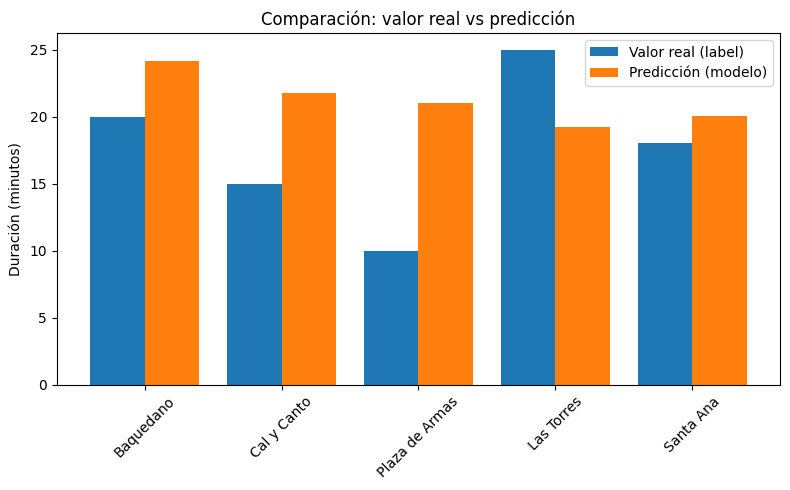

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir las predicciones a Pandas
pdf = predicciones_nuevas.select("estacion", "label", "prediction").toPandas()

# Crear gráfico de barras
plt.figure(figsize=(8,5))
x = range(len(pdf))

plt.bar(x, pdf["label"], width=0.4, label="Valor real (label)", align="center")
plt.bar([i + 0.4 for i in x], pdf["prediction"], width=0.4, label="Predicción (modelo)", align="center")

plt.xticks([i + 0.2 for i in x], pdf["estacion"], rotation=45)
plt.ylabel("Duración (minutos)")
plt.title("Comparación: valor real vs predicción")
plt.legend()
plt.tight_layout()
plt.show()


# 🔹 Paso 8: Árbol de Regresión
Probamos un modelo alternativo más flexible: **DecisionTreeRegressor**.  
- Entrenamos con los mismos datos de entrenamiento.  
- Evaluamos con RMSE, MAE y R².  
- Los árboles pueden capturar mejor los casos extremos que la regresión lineal.

In [ ]:
# ✅ Paso 8: Árbol de Regresión en MLlib
from pyspark.ml.regression import DecisionTreeRegressor

# 1) Definir el modelo de árbol
dt = DecisionTreeRegressor(featuresCol="features", labelCol="label", maxDepth=5)

# 2) Entrenar con el mismo train_df del paso 5
dt_model = dt.fit(train_df)

# 3) Predicciones en test
dt_preds = dt_model.transform(test_df)
dt_preds.select("prediction", "label").show(10, truncate=False)

# 4) Evaluación
rmse_dt = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction").evaluate(dt_preds)
mae_dt  = RegressionEvaluator(metricName="mae",  labelCol="label", predictionCol="prediction").evaluate(dt_preds)
r2_dt   = RegressionEvaluator(metricName="r2",   labelCol="label", predictionCol="prediction").evaluate(dt_preds)

print("🔹 Árbol de Regresión")
print(f"   RMSE: {rmse_dt:.2f}")
print(f"   MAE : {mae_dt:.2f}")
print(f"   R²  : {r2_dt:.3f}")

# 5) (Opcional) Visualizar la estructura del árbol aprendido
print("\n🔹 Estructura del árbol:")
print(dt_model.toDebugString)


+------------------+-----+
|prediction        |label|
+------------------+-----+
|15.0              |15   |
|21.428571428571427|20   |
|27.5              |25   |
|20.0              |25   |
|25.714285714285715|25   |
|25.0              |15   |
|25.0              |20   |
|20.0              |20   |
|21.428571428571427|15   |
|26.0              |25   |
+------------------+-----+
only showing top 10 rows

🔹 Árbol de Regresión
   RMSE: 5.61
   MAE : 4.12
   R²  : -0.092

🔹 Estructura del árbol:
DecisionTreeRegressionModel: uid=DecisionTreeRegressor_2b9a737c7a63, depth=5, numNodes=55, numFeatures=4
  If (feature 2 in {0.0,2.0,4.0})
   If (feature 1 in {2.0,3.0,6.0,8.0,9.0,12.0,13.0,14.0,15.0,16.0})
    If (feature 0 in {1.0,2.0,4.0,6.0})
     If (feature 1 in {15.0})
      Predict: 10.0
     Else (feature 1 not in {15.0})
      If (feature 2 in {0.0,4.0})
       Predict: 16.956521739130434
      Else (feature 2 not in {0.0,4.0})
       Predict: 19.5
    Else (feature 0 not in {1.0,2.0,4.0,6.0

# 🔹 Paso 9: Comparación de modelos
Creamos un gráfico comparando métricas de **Regresión Lineal vs Árbol de Regresión**.  
- RMSE y MAE → indican qué modelo comete menos error.  
- R² → muestra cuál explica mejor la variabilidad.  
Esto nos ayuda a decidir qué modelo es más apropiado para los datos del Metro de Santiago.

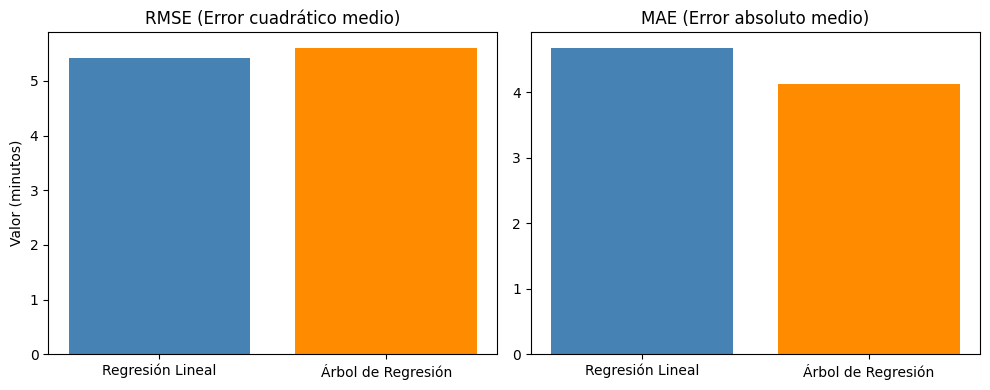

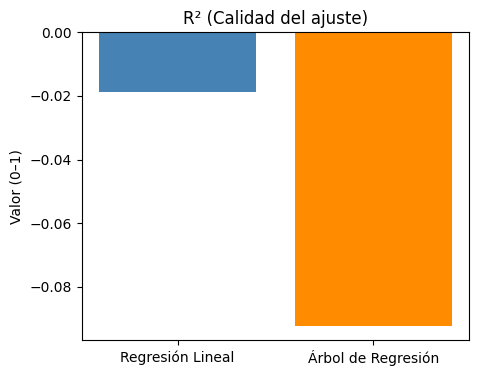

In [ ]:
import matplotlib.pyplot as plt

# Métricas obtenidas previamente
metrics = {
    "Regresión Lineal": {"RMSE": rmse, "MAE": mae, "R²": r2},
    "Árbol de Regresión": {"RMSE": rmse_dt, "MAE": mae_dt, "R²": r2_dt}
}

# Convertir a listas para graficar
modelos = list(metrics.keys())
rmse_vals = [metrics[m]["RMSE"] for m in modelos]
mae_vals  = [metrics[m]["MAE"] for m in modelos]
r2_vals   = [metrics[m]["R²"]  for m in modelos]

# Gráfico de RMSE y MAE (error, menor es mejor)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(modelos, rmse_vals, color=["steelblue","darkorange"])
plt.title("RMSE (Error cuadrático medio)")
plt.ylabel("Valor (minutos)")

plt.subplot(1,2,2)
plt.bar(modelos, mae_vals, color=["steelblue","darkorange"])
plt.title("MAE (Error absoluto medio)")

plt.tight_layout()
plt.show()

# Gráfico de R² (explicación de varianza, mayor es mejor)
plt.figure(figsize=(5,4))
plt.bar(modelos, r2_vals, color=["steelblue","darkorange"])
plt.title("R² (Calidad del ajuste)")
plt.ylabel("Valor (0–1)")
plt.show()


# 📌 Conclusiones del Proyecto

1. **Preparación de datos en Spark**  
   - Confirmamos que Spark MLlib requiere que los datos estén en el formato estándar:  
     - `features` → vector con todas las variables de entrada.  
     - `label` → columna objetivo que queremos predecir.  
   - Usamos `StringIndexer` para variables categóricas y `VectorAssembler` para crear el vector de características.  

2. **Modelo de Regresión Lineal**  
   - Se entrenó un modelo inicial para predecir la duración de incidentes en el Metro de Santiago.  
   - Los resultados mostraron errores promedio de ~5 minutos y un R² cercano a 0, indicando que el modelo no logra explicar bien la variabilidad.  
   - Esto es esperable debido al tamaño reducido del dataset y a la simplicidad del modelo.  

3. **Modelo de Árbol de Regresión**  
   - Probamos un modelo alternativo (árbol de decisión) que redujo un poco el MAE.  
   - Aunque sigue limitado por la cantidad de datos, mostró mejor capacidad de capturar variaciones extremas.  

4. **Visualización y validación**  
   - Comparar predicciones vs valores reales en gráficos ayudó a ver claramente el sesgo de la regresión lineal (predice cerca del promedio).  
   - El árbol de regresión resultó más flexible, aunque con un rendimiento global similar.  

5. **Aprendizajes clave**  
   - Spark MLlib es más útil con **datasets grandes** (decenas de miles de registros en adelante).  
   - Para ejercicios educativos, incluso con pocos datos, es una excelente forma de practicar el flujo completo de ML en Spark.  
   - La elección del modelo depende del tipo de datos:  
     - Regresión lineal → buena como baseline, pero muy simple.  
     - Árboles/Random Forest/Gradient Boosted Trees → más potentes para datos categóricos y no lineales.  

---

✅ Con este proyecto recorrimos todo el flujo de **Machine Learning con Spark MLlib**:  
desde la carga de datos, preparación, construcción del pipeline, entrenamiento, evaluación y comparación de modelos.  